In [1]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [2]:
train = pd.read_csv('/home/saule/Light_GBM/Data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
test = pd.read_csv('/home/saule/Light_GBM/Data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# Смотрим кол-во ненулевых значений
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 10)
pd.DataFrame(data={'NaN_count': train.isna().sum(), 'data_type':train.dtypes})

,NaN_count,data_type
Id,0,int64
MSSubClass,0,int64
MSZoning,0,object
LotFrontage,259,float64
LotArea,0,int64
...,...,...
MoSold,0,int64
YrSold,0,int64
SaleType,0,object
SaleCondition,0,object


In [5]:
# Разделим признаки на числовые и категориальные, тк их обработка будет принциально отличаться
num_features = train.select_dtypes(exclude='object')
cat_features = train.select_dtypes(include='object')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<BarContainer object of 1460 artists>

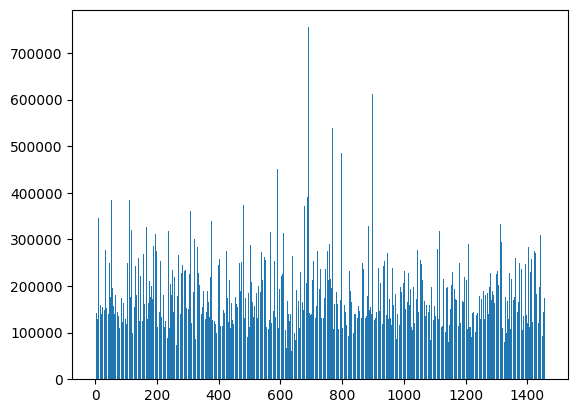

In [6]:
plt.bar(train.index, train['SalePrice'])

In [7]:
train = train[train['SalePrice'] <= 300000]
train['SalePrice'].describe()

count      1345.000000
mean     164246.190335
std       52094.670262
min       34900.000000
25%      128000.000000
50%      156000.000000
75%      196000.000000
max      299800.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

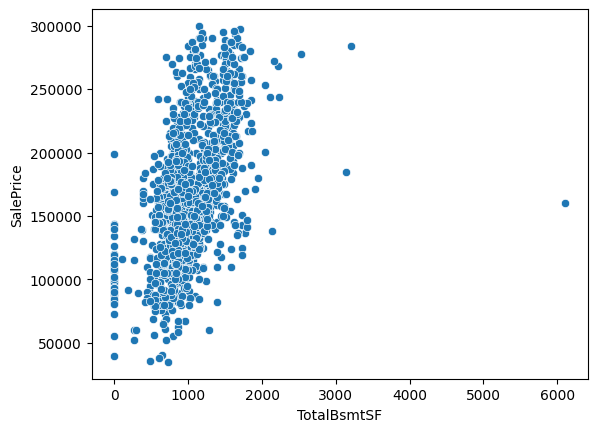

In [8]:
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')

In [9]:
train = train[train['TotalBsmtSF'] <= 2000]

In [10]:
train['SalePrice'] = np.log(train['SalePrice'])
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [11]:
# Разделим сразу на features и target (таргет у нас test.csv)

X, y = train.drop('SalePrice', axis=1), train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)



#### 1.1 Imputation (Заполнение пропусков) 

In [12]:
# Удаляем неинформативные колонки
drop_features = ['Id', "SaleType","YrSold","MiscVal","3SsnPorch","MoSold","FireplaceQu","MiscFeature","PoolArea", \
                 'Alley', 'MasVnrType', 'Utilities', 'RoofMatl', 'BsmtQual', 'BsmtCond', 'Electrical', 'Condition1', \
                 'Condition2', 'Exterior1st', 'Exterior2nd', 'Heating', 'LandSlope', 'Functional', 'ExterQual', 'ExterCond',\
                '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'PoolQC','Fence'] # Alley - тип доступа в переулок (94% пропусков),
# MasVnrType - тип каменной облицовки (59% пропусков)
nan_columns = ['GarageType','GarageFinish','GarageQual','GarageCond', \
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"MSZoning","KitchenQual"]

numerical_features = [col for col in X.columns if X[col].dtype != 'object']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        #('num_imputer', SimpleImputer(strategy='median'), ['LotFrontage','MasVnrArea']), # LotFrontage - погонные футы улицыБ соединенные с участком (17% пропусков),
        # MasVnrArea - площадь каменного шпона в квадратных футах
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), numerical_features)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

#### 1.3 Encoding and Scaling (Кодирование и нормировка данных)

In [13]:
ordinal_encoding_columns = ['KitchenQual','GarageFinish','GarageQual','GarageCond',\
                           'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', \
                           'BldgType', 'HouseStyle','RoofStyle','Neighborhood', \
                           'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
                           'HeatingQC']
standard_scaler_columns = ['TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
                          'OpenPorchSF','EnclosedPorch','ScreenPorch',\
                          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
one_hot_encoding_columns = ['GarageType','PavedDrive','SaleCondition', 'CentralAir']


scaler_and_encoder = ColumnTransformer(
    [
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), numerical_features),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

#### 1.4 total Preprocessor

In [14]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [15]:
preprocessor 

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['Id', 'SaleType', 'YrSold',
                                                   'MiscVal', '3SsnPorch',
                                                   'MoSold', 'FireplaceQu',
                                                   'MiscFeature', 'PoolArea',
                                                   'Alley', 'MasVnrType',
                                                   'Utilities', 'RoofMatl',
                                                   'BsmtQual', 'BsmtCond',
                                                   'Electrical', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Heating',
                                                   'Lan...
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF', ...]),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  ['KitchenQual',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'MSZoning',
                                                   'Street', 'LotShape',
                                                   'LandContour', 'LotConfig',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Neighborhood',
                                                   'Foundation', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2',
                                                   'HeatingQC'])],
                                   verbose_feature_names_out=False))])

In [16]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ]
)


In [17]:
ml_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['Id',
                                                                    'SaleType',
                                                                    'YrSold',
                                                                    'MiscVal',
                                                                    '3SsnPorch',
                                                                    'MoSold',
                                                                    'FireplaceQu',
                                                                    'MiscFeature',
                                                                    'PoolArea',
                                                                    'Alley',
                                                                    'MasVnrType',
                                                                    'Utilities',
                                                                    'RoofMatl',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'Electrical',
                                                                    'Condition1',
                                                                    'Condition2',
                                                                    'Exterior1...
                                                                    'OpenPorchSF', ...]),
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['KitchenQual',
                                                                    'GarageFinish',
                                                                    'GarageQual',
                                                                    'GarageCond',
                                                                    'MSZoning',
                                                                    'Street',
                                                                    'LotShape',
                                                                    'LandContour',
                                                                    'LotConfig',
                                                                    'BldgType',
                                                                    'HouseStyle',
                                                                    'RoofStyle',
                                                                    'Neighborhood',
                                                                    'Foundation',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'HeatingQC'])],
                                                    verbose_feature_names_out=False))])),
                ('model', RandomForestRegressor())])

In [18]:
tree = ml_pipeline.fit(X_train, y_train)

In [19]:
predictions = ml_pipeline.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False) # Вычислите RMSE
print("RMSE модели:", rmse)

RMSE модели: 0.04788162574394161


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [20]:
y_pred_valid = ml_pipeline.predict(X_valid)# Вычисляем RMSE
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print("RMSE на валидационной выборке:", rmse_valid)

RMSE на валидационной выборке: 0.14662116079166893


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**CatBoost**

In [222]:
X_prep = preprocessor.fit_transform(X_train) 
X_prep_valid = preprocessor.fit_transform(X_valid) 

In [224]:
from catboost import CatBoostRegressor

In [225]:
model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_prep, y_train, verbose=False, plot=False)

In [226]:
predict_cat_boost = model.predict(X_prep)
rmse_cat_boost = mean_squared_error(y_train, predict_cat_boost, squared=False) # Вычислите RMSE
print("RMSE модели:", rmse_cat_boost)

RMSE модели: 0.0577875803749539


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [227]:
predict_cat_boost_valid = model.predict(X_prep_valid)
rmse_cat_boost_valid = mean_squared_error(y_valid, predict_cat_boost_valid, squared=False) # Вычислите RMSE
print("RMSE модели:", rmse_cat_boost_valid)

RMSE модели: 0.16594564347829321


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Shap**

In [27]:
import shap

In [28]:
shap.initjs()

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_prep)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_prep.iloc[0,:])

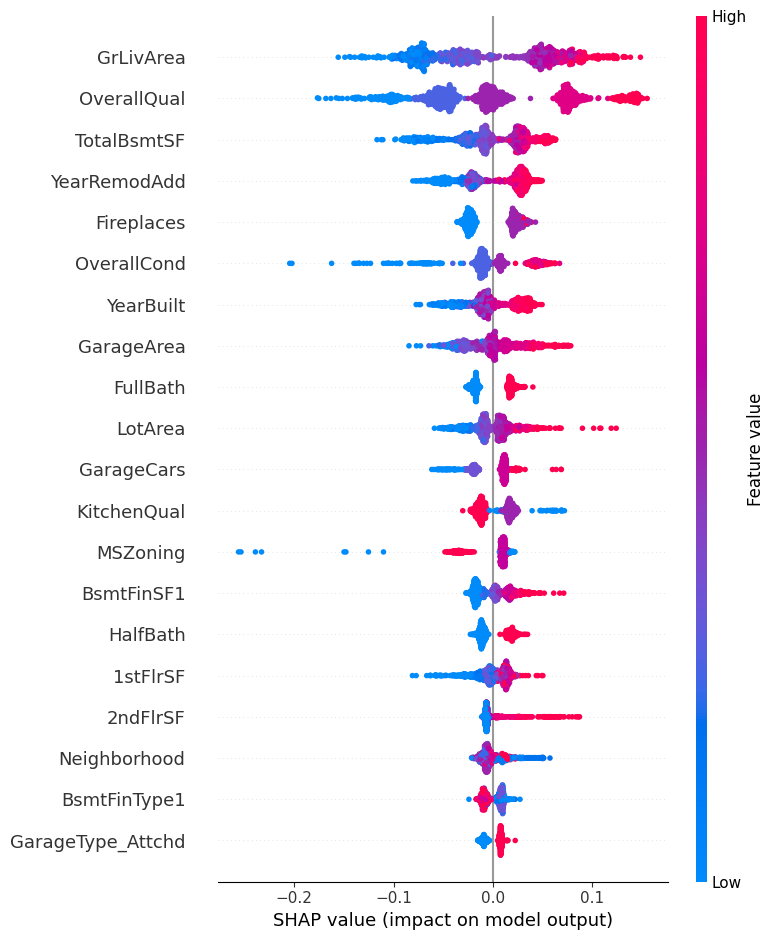

In [30]:
shap.summary_plot(shap_values, X_prep)

**Permutation importance**

In [46]:
r = permutation_importance(tree, X_valid, y_valid, n_repeats=30, random_state=0)
importance = pd.Series(dict(zip(X.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)
importance

OverallQual    0.226067
GrLivArea      0.177990
TotalBsmtSF    0.040105
BsmtFinSF1     0.019218
LotArea        0.014104
                 ...   
ExterQual      0.000000
Heating        0.000000
Exterior2nd    0.000000
MasVnrType     0.000000
ExterCond      0.000000
Length: 80, dtype: float64

In [ ]:
preprocessor.fit_transform(test)

In [ ]:
answer = ml_pipeline.predict(test)

In [ ]:
ans = test[['Id']].copy()
ans.insert(1, "SalePrice", answer, True)
ans['SalePrice'] = ans['SalePrice'].map(lambda a: np.exp(a))
ans.to_csv('submission.csv', index=False)

In [ ]:
ans['SalePrice'] = ans['SalePrice'].map(lambda a: np.exp(a))

In [ ]:
ans.to_csv('submission.csv', index=False)

In [ ]:
import joblib

In [ ]:
joblib.dump(ml_pipeline, 'ml_pipeline_house.pkl')

**New preprocess**

In [75]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [194]:
from sklearn.preprocessing import FunctionTransformer

def round_to_tens(X):
    X['YearBuilt'] = X['YearBuilt'].apply(lambda x: round(x, -1))
    X['YearRemodAdd'] = X['YearRemodAdd'].apply(lambda x: round(x, -1))
    return X

round_transformer = FunctionTransformer(round_to_tens)


In [212]:
# Удаляем неинформативные колонки
drop_features = ['Id', 'MSSubClass', 'MSZoning', 'Alley', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2',
                'HouseStyle', 'OverallCond', 'OverallQual', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                'Heating', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'BedroomAbvGr', 
                'Functional', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'MasVnrType', 'ExterCond', 'BsmtCond', 'Foundation', 'BsmtFinType1', 'BldgType', 'CentralAir', 'KitchenQual',
                'GarageType', 'ExterQual', 'ExterQual', 'BsmtExposure', 'BsmtQual', 'SaleType'] 

nan_columns = ['Neighborhood', 'PavedDrive', 'SaleCondition']

numerical_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'GarageCars', 'FullBath',\
                     'TotRmsAbvGrd']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('num_imputer', SimpleImputer(strategy='most_frequent'), numerical_features)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

In [213]:
ordinal_encoding_columns = ['Neighborhood', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'PavedDrive', 'SaleCondition']
standard_scaler_columns = ['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageArea', 'WoodDeckSF']
# one_hot_encoding_columns = ['CentralAir']

scaler_and_encoder = ColumnTransformer(
    [
      #  ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [214]:
preprocessor_new = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('round_transformer', round_transformer)
    ]
)

In [245]:
from sklearn.metrics import mean_squared_error, r2_score

**RandomForest**

In [239]:
X_prep = preprocessor_new.fit_transform(X_train) 
X_prep_valid = preprocessor_new.fit_transform(X_valid) 

In [247]:
model = RandomForestRegressor(random_state=42)
model = model.fit(X_prep, y_train)
y_pred = model.predict(X_prep)
rmse_valid = mean_squared_error(y_train, y_pred, squared=False)
print("RMSE на train выборке:", rmse)
r2 = r2_score(y_train, y_pred)
print(f"R² на train выборке: {r2}")

RMSE на train выборке: 0.05525914471028864
R² на train выборке: 0.9730043321365995


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [246]:
y_pred_valid = model.predict(X_prep_valid)
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print("RMSE на валидационной выборке:", rmse_valid)
r2_valid = r2_score(y_valid, y_pred_valid)
print(f"R² на валидационной выборке: {r2_valid}")

RMSE на валидационной выборке: 0.16682006415256634
R² на валидационной выборке: 0.7534504721399378


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [219]:
# Получаем список колонок после обработки в ColumnTransformer
processed_columns = preprocessor_new.named_steps['scaler_and_encoder'].get_feature_names_out()# Определяем индекс проблемного столбца
problematic_column_index = 2
problematic_column_name = processed_columns[problematic_column_index]
print(f"Проблемный столбец: {problematic_column_name}")# Проверяем уникальные значения в проблемном столбце
print(f"Уникальные значения в проблемном столбце (тренировочный набор): {X_train[problematic_column_name].unique()}")
print(f"Уникальные значения в проблемном столбце (валидационный набор): {X_valid[problematic_column_name].unique()}")

Проблемный столбец: TotalBsmtSF
Уникальные значения в проблемном столбце (тренировочный набор): [ 672    0  799 1408 1086 1165  735  483 1026 1602 1362  990 1498  750
 1052 1164  912 1541  547  861 1251 1200 1616  864 1567 1517  872  596
  884  816 1269 1094  840  723 1056 1606 1152 1573 1489  804  808 1374
 1088  602  876  641 1344  728 1273 1368 1064 1051  822  958 1055 1478
  689  953  918 1504  690  952  648  976 1012  755  716  791 1300  720
  636  290 1053 1328  458 1013  768  384 1657 1372 1347  793  576 1392
  868  980  780  658  747  896 1113  979  866 1063  707  930  951 1286
  796 1461  940  916 1214 1734  907 1373  546 1593  756  625  828  832
 1682  697 1268  969 1162 1224  544 1241 1440  673  825  960 1090 1092
  970 1533  883  630  901  924  612 1306  585 1660 1565 1496  525 1161
  928 1142  528  773  744 1150 1561  802  936 1080  536 1324  764 1720
 1199 1454  600  992  270 1022 1223 1120  954  777 1574  994 1277 1050
 1054  660 1375  655 1073  879 1763 1584  925  588  

In [248]:
test_tranf = preprocessor_new.fit_transform(test) 

In [249]:
answer_new = model.predict(test_tranf)

In [250]:
ans = test[['Id']].copy()
ans.insert(1, "SalePrice", answer_new, True)
ans['SalePrice'] = ans['SalePrice'].map(lambda a: np.exp(a))
ans.to_csv('submission_2.csv', index=False)